# Quadratic Plot toy

We consider data generated according to the following process. 
A latent variable $ x_0 $ is first sampled uniformly from the interval $[-1, 1]$. The corresponding noiseless target is defined as
    $$y_0 = -x_0^2 + 1.$$
Observed samples $(x, y)$ are then obtained by adding independent Gaussian noise:
    $$x \sim \mathcal{N}(x_0, \sigma^2), 
    \qquad 
    y \sim \mathcal{N}(y_0, \sigma^2),
    \qquad
    z = (x,y)$$
where $\sigma > 0$ controls the level of observational noise.

## Imports and Seeds

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer
import torch
import random
from torch.utils.data import Dataset, DataLoader # to delete later
from scipy.stats import wasserstein_distance

In [2]:
seed = 42
# Python built-in RNG
random.seed(seed)
# NumPy RNG
np.random.seed(seed)

# PyTorch RNG (CPU + CUDA)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

# For reproducibility in cuDNN backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
mode = "training"
dataset = "mnist"

In [ ]:
if dataset == "quad":
    N = 500000
    x_0 = np.random.uniform(low = -1, high = 1, size = (N, ))
    y_0 = - x_0**2 + 1
    x_0 = (x_0 + 1)/2
    z_0 = np.stack((x_0, y_0), axis = 1)

    training_data = torch.tensor(z_0).unsqueeze(-1).unsqueeze(-1) # images are normalized from 0 to 1

    print(f"Training data has shape {training_data.shape} and type {training_data.dtype} with min x {training_data[:,0,:,:].min().item()} max {training_data[:,0,:,:].max().item()}")

    torch.save(training_data, f"training_data_{N}.pt")
elif dataset == "mnist":
    pass

Training data has shape torch.Size([500000, 2, 1, 1]) and type torch.float64 with min x 2.2272957072022592e-06 max 0.9999983148609545


## 

In [4]:
model = Unet(
    dim = 64,
    dim_mults=(1,),
    flash_attn = True,
    channels = 2,          
    out_dim = 2
).cuda()

diffusion = GaussianDiffusion(
    model,
    image_size = 1,
    timesteps = 1000,           # number of steps
    sampling_timesteps = 1000,    # number of sampling timesteps (using ddim for faster inference [see citation for ddim paper])
    objective = 'pred_noise'
).cuda()

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


In [5]:
train_num_steps = 1000

# trainer = Trainer(
#     diffusion,
#     f'training_data_{N}.pt',
#     is_image = False,
#     train_batch_size = 500,
#     train_lr = 8e-5,
#     train_num_steps = train_num_steps,         # total training steps
#     gradient_accumulate_every = 2,    # gradient accumulation steps
#     ema_decay = 0.995,                # exponential moving average decay
#     amp = True,                       # turn on mixed precision
#     calculate_fid = False              # whether to calculate fid during training
# )

# trainer.train()
# torch.save(model.state_dict(), f'model_final_{train_num_steps}.pt')

model.load_state_dict(torch.load(f'model_final_{train_num_steps}.pt', map_location='cpu'))

<All keys matched successfully>

In [6]:
def plot_and_wass(riemann):
    x_wass = []
    y_wass = []

    # keep sampling until you have 1000 total points
    while len(x_wass) < 50000:
        sampled_images = diffusion.sample(batch_size=1000, riemann=riemann)
        sampled_plotting = sampled_images.squeeze(-1).squeeze(-1)  # [bs, 2]
        x = sampled_plotting[:, 0].cpu().numpy()
        y = sampled_plotting[:, 1].cpu().numpy()

        # extend lists
        x_wass.extend(x)
        y_wass.extend(y)

    # convert to numpy arrays
    x_wass = np.array(x_wass[:1000])
    y_wass = np.array(y_wass[:1000])

    # Wasserstein distance (assuming x_0, y_0 are defined)
    x_wass_dist = wasserstein_distance(x_0, x_wass)
    y_wass_dist = wasserstein_distance(y_0, y_wass)

    print(f"x Wasserstein: {x_wass_dist:.4f}")
    print(f"y Wasserstein: {y_wass_dist:.4f}")

    # plot samples
    color = "orange" if riemann else "blue"
    plt.scatter(x_wass, y_wass, color=color, alpha=0.5)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Samples ({'Riemann' if riemann else 'Vanilla'})")
    plt.show()

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

x Wasserstein: 0.0207
y Wasserstein: 0.0461


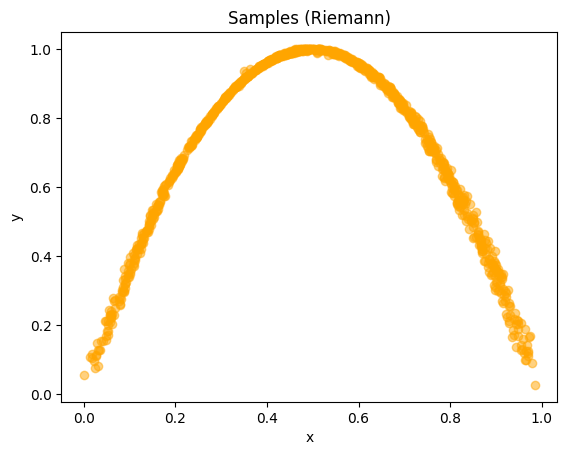

In [7]:
plot_and_wass(True)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

x Wasserstein: 0.0150
y Wasserstein: 0.0200


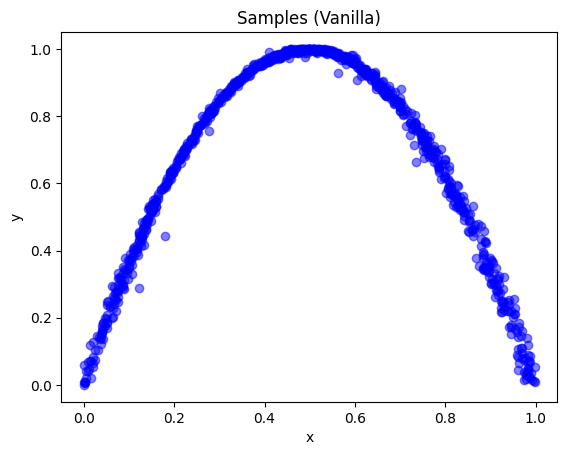

In [8]:
plot_and_wass(False)